# Memphis Metropolitan Statistical Area (MMSA) Example subject

The MMSA was selected as a testbed for research studies by the NIST Center for Risk-Based Community Resilience Planning to test algorithms developed for community resilience assessment on a large urban area with a diverse population and economy. The population of Memphis, Shelby County, and MMSA, respectively, are about 0.7 M, 1.0 M, and 1.4 M. This dense population lies within the most seismically active area of Central and Eastern United States, called the New Madrid Seismic Zone (NMSZ), which is capable of producing large damaging earthquakes. 

This notebook perform seismic damage and functionality analysis of interdependent buildings, electric power and water distribution network systems of Shelby County, TN. First the geospatial infrastructure inventory and service area dataset are imported to characterize the buildings and lifeline systems of the MMSA testbed and the interdependency between infrastructure systems. Then, scenario earthquakes obtained from a ground motion prediction model to generate spatial intensity measures for the infrastructure network area and perform damage analysis to obtain component-level damage probability estimates subject to the scenario earthquake.This is followed by developing a fragility-based computational model of the networked infrastructure using graph theory where components are modeled as nodes, and the connection between nodes are modeled as directed links. The outcome of component level structural damage assessment is used to perform functionality and restoration analysis of buildings and networks by considering the interdependency between infrastructure systems and the cascading failure of each network component using an input-output model. 

* This notebook was developed by Milad Roohi (CSU/UNL - milad.roohi@unl.edu) in colaboration with Jiate Li (CSU) and John W. van de Lindt (CSU), the NCSA team (Jong Sung Lee, Chris Navarro, Diego Calderon, Chen Wang, Michal Ondrejcek, Gowtham Naraharisetty).

## References

[1] Atkinson GM, Boore DM. (1995) Ground-motion relations for eastern North America. Bulletin of the Seismological Society of America. 1995 Feb 1;85(1):17-30.

[2] Elnashai, A.S., Cleveland, L.J., Jefferson, T., and Harrald, J., (2008). “Impact of Earthquakes on the Central USA” A Report of the Mid-America Earthquake Center. http://mae.cee.illinois.edu/publications/publications_reports.html![image.png](attachment:97c026ce-8248-481d-b109-e48fd108e38e.png)![image.png](attachment:a4706ad2-73ed-430a-ab45-4c6f56307d29.png)![image.png](attachment:6ec6d200-f0bb-45a8-b6c1-3acc03f041fa.png)![image.png](attachment:1772e5a6-1560-433f-b3e0-60edc7d68d90.png)

[3] Linger S, Wolinsky M. (2001) Los Alamos National Laboratory Report LA-UR-01-3361 ESRI Paper No. 889 Estimating Electrical Service Areas Using GIS and Cellular Automata.

[4] Roohi M, van de Lindt JW, Rosenheim N, Hu Y, Cutler H. (2021) Implication of building inventory accuracy on physical and socio-economic resilience metrics for informed decision-making in natural hazards. Structure and Infrastructure Engineering. 2020 Nov 20;17(4):534-54.

[5] Federal Emergency Management Agency (FEMA). (2020) Hazus Earthquake Model Technical Manual. 2020 Oct.

[6] Haimes YY, Horowitz BM, Lambert JH, Santos JR, Lian C, Crowther KG. (2005) Inoperability input-output model for interdependent infrastructure sectors. I: Theory and methodology. Journal of Infrastructure Systems. 2005 Jun;11(2):67-79.

[7] Milad Roohi, Jiate Li, John van de Lindt. (2022) Seismic Functionality Analysis of Interdependent Buildings and Lifeline Systems 12th National Conference on Earthquake Engineering (12NCEE), Salt Lake City, UT (June 27-July 1, 2022).

# Prerequisites

In [3]:
from pyincore import HazardService, IncoreClient, Dataset, FragilityService, MappingSet, DataService, SpaceService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.pipelinedamagerepairrate import PipelineDamageRepairRate
from pyincore.analyses.waterfacilitydamage import WaterFacilityDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore_viz.geoutil import GeoUtil as viz
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability

import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import contextily as cx

import copy

from scipy.stats import poisson,bernoulli

import matplotlib.pyplot as plt

client = IncoreClient()

Enter username: snunez
Enter password: ········
Connection successful to IN-CORE services. pyIncore version detected: 1.6.0


# 1) Define Earthquake Hazard Scenarios

Scenario earthquakes are created using Atkinson and Boore (1995) [1] GMPE model including earthquakes with magnitudes $M_w5.9$, $M_w6.5$ and $M_w7.1$ to study the effect of seismic hazard intensity in resilience metrics. The scenario can be selected by defining selecting earthquake magnitude using "select_EQ_magnitude" parameter.

In [4]:
#### Define hazard type
hazard_type = "earthquake"

#### Select the earthquake scenario magnitude from the following 'EQ_hazard_dict' dictionary keys
select_EQ_magnitude = 7.1

#### Define hazard dictionary with three ground motion intensity levels
EQ_hazard_dict = {}
EQ_hazard_dict[5.9] = {'id': "5e3db155edc9fa00085d7c09", 'name':'M59'}
EQ_hazard_dict[6.5] = {'id': "5e45a1308591b700088c799c", 'name':'M65'}
EQ_hazard_dict[7.1] = {'id': "5e3dd04f7fdf7e0008032bfe", 'name':'M71'}



In [5]:
#### Define filename and create folder for saving results
hazard_id = EQ_hazard_dict[select_EQ_magnitude]['id']
hazard_name = EQ_hazard_dict[select_EQ_magnitude]['name']

import os
current_path = os.getcwd()

#### create folder "MMSA_analysis_results" to save results
results_folder = "MMSA_analysis_results"
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

#### define folder path for each eathquake magnitude to save results in different folders
fp = current_path + '/' + results_folder + '/' + hazard_name
if not os.path.isdir(fp):
    os.makedirs(fp)
fp = fp + '/' 

# 2) Define Infrastructure Inventory Data

### 2-1) Building Inventory Data

The Mid-America Earthquake (MAE) center [2] initiated the Memphis testbed (MTB) project to demonstrate the seismic risk assessment to the civil infrastructure system in Shelby County, TN. As part of that project, a high-resolution model of the physical and social infrastructure was developed to investigate the potential impact due to earthquake activity in the New Madrid Seismic Zone (NMSZ) (Elnashai et al., 2008). 

The building inventory is defined based on the Shelby county shapefile available on the IN-CORE data service (ID: 5a284f0bc7d30d13bc081a46). This study considers all the buildings with a total number of 306003.

In [24]:
#### Building inventory dataset for Shelby county, TN
bldg_dataset_id = "5a284f0bc7d30d13bc081a46"  

# #### Import building dataset from IN-CORE data service
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, DataService(client))

# #### Convert building dataset to geodataframe
bldg_gdf = bldg_dataset.get_dataframe_from_shapefile()
bldg_gdf.head()

,parid,parid_card,bldg_id,struct_typ,str_prob,year_built,no_stories,a_stories,b_stories,bsmt_type,...,dgn_lvl,cont_val,efacility,dwell_unit,str_typ2,occ_typ2,tract_id,guid,IMPUTED,geometry
0,038035 00019,038035 00019_1,038035 00019_1_1,URM,0.02633,1920,1,1,0,CRAWL=0-24%,...,Pre - Code,46707,FALSE,1,URML,RES1,47157001300,64124791-1502-48ea-81b6-1992855f45d5,F,POINT (-89.94883 35.15122)
1,038034 00040,038034 00040_1,038034 00040_1_1,W1,0.97366,1947,1,1,0,CRAWL=0-24%,...,Low - Code,39656,FALSE,1,W1,RES1,47157001300,d04da316-7cba-4964-8104-f0edfde18239,F,POINT (-89.95095 35.15284)
2,038028 00023,038028 00023_1,038028 00023_1_1,W1,0.97366,1900,1,1,0,CRAWL=0-24%,...,Low - Code,37765,FALSE,1,W1,RES1,47157001300,c24d708d-a21b-416f-8772-965548407231,F,POINT (-89.95022 35.15976)
3,034011 00008,034011 00008_1,034011 00008_1_1,W1,0.97366,1926,1,1,0,CRAWL=0-24%,...,Low - Code,59930,FALSE,1,W1,RES1,47157005700,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,F,POINT (-90.04844 35.10446)
4,034011 00007,034011 00007_1,034011 00007_1_1,W1,0.97366,1926,1,1,0,CRAWL=0-24%,...,Low - Code,65276,FALSE,1,W1,RES1,47157005700,ef25f515-4109-408f-a3d4-3b79da49edd0,F,POINT (-90.04843 35.10459)


#### Structural system type statistics of MMSA building inventory

In [7]:
pivot= bldg_gdf.pivot_table(
     index='struct_typ',
     values='guid',
     aggfunc=np.count_nonzero
)
pivot.columns = ['Count']
pivot.sort_values('Count',ascending=False)

,Count
struct_typ,
W1,271853
W2,12097
URM,11141
S1,3608
S3,3522
RM,1600
PC1,1110
C1,913
C2,81


### 2-2) Electric Power Network (EPN) Inventory Data

In [10]:
### Read EPN node and link inventory data
df_EPNnodes  = gpd.read_file("shapefiles/Mem_power_link5_node.shp")
df_EPNlinks  = gpd.read_file("shapefiles/Mem_power_link5.shp")

### Plot EPN shapefiles
ax = df_EPNnodes.plot(figsize=(20, 10), column='utilfcltyc', categorical=True, markersize=150, legend=True,)
df_EPNlinks.plot(ax=ax, color='k')
cx.add_basemap(ax, crs=df_EPNnodes.crs)

INFO - collection.py:crs() - Failed to auto identify EPSG: 7
INFO - collection.py:crs() - Failed to auto identify EPSG: 7


### 2-3) Water Distribution System (WDS) Inventory Data

In [27]:
### Read WDS node and link inventory data
df_WDSnodes  = gpd.read_file("shapefiles/Mem_water_node5.shp")
df_WDSlinks  = gpd.read_file("shapefiles/Mem_water_pipeline_node_Modified.shp")

### Plot WDS shapefiles
ax = df_WDSnodes.plot(figsize=(20, 10), column='utilfcltyc', categorical=True, markersize=150, legend=True,)
df_WDSlinks.plot(ax=ax, color='k')
cx.add_basemap(ax, crs=df_WDSnodes.crs)

INFO - collection.py:crs() - Failed to auto identify EPSG: 7


### 2-4) EPN service area dataset 

The interdependency between buildings and utility network infrastructure is modeled by using a Cellular Automata algorithm [3] to estimate the service areas of each network component and perform geospatial analysis to identify the buildings located within the service area of each component. A CSV file ("Memphis_EPN_Bldg_Depend.csv") has been developd that maps each of the EPN substations to corresponsing buildings within the node's service area.

In [12]:
### Load the service are mapping between EPN nodes (i.e., sguid) and buildings (i.e., guid)
filepath = 'Inputs/Memphis_EPN_Bldg_Depend.csv'
df_EPN_Bldg_Depend = pd.read_csv(filepath, index_col=False)
df_EPN_Bldg_Depend = df_EPN_Bldg_Depend.rename(columns={'Bldg_guid': 'guid', 'Substation_guid':'sguid'})
df_EPN_Bldg_Depend.head()

,Unnamed: 0,guid,sguid
0,0,4014e650-a282-47a0-8b05-be64f92541fe,5f5b4d4e-14c9-4d32-9327-81f1c37f5730
1,1,c57a33ff-9cf9-45ec-9c2e-86bba4d585a1,5f5b4d4e-14c9-4d32-9327-81f1c37f5730
2,2,398ef608-bcf8-4a15-bfc8-01273c9c36c2,5f5b4d4e-14c9-4d32-9327-81f1c37f5730
3,3,0d96300b-0301-41c2-b19c-85a3c8f4c142,5f5b4d4e-14c9-4d32-9327-81f1c37f5730
4,4,25e640e5-f6ae-4b6d-a777-4dfcbb818961,5f5b4d4e-14c9-4d32-9327-81f1c37f5730


# 3) Infrastructure Damage Analysis

### 3-1) Buildings Physical Damage, MC and Functionality Analysis


The "BuildingDamage" module of pyincore is used for building damage analysis. This module requires specifying the building inventory data cases and fragility mapping set, scenario hazard tye ad ID and subsequently run analysis to estimate probability of exceeding various damage states. 

The fragility mappings are performed based on the value of five attributes, including the number of stories (“no_stories”), the occupancy type (“occ_type”), the year built (“year_built”), the structural type (“struct_typ”), and “efacility”. Once the rules in the mapping file (ID=5b47b2d9337d4a36187c7564) are satisfied, mapping IDs from the fragility service are returned to map fragility parameters to each node of the model. 


#### 3-1-A) Damage Analysis

In [13]:
#### Import building damage analyis module from pyincore.
from pyincore.analyses.buildingdamage import BuildingDamage  

In [14]:
bldg_dmg = BuildingDamage(client)

#### Load building input dataset
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id) 

#### Load fragility mapping
fragility_service = FragilityService(client)
mapping_id = "5b47b2d9337d4a36187c7564"

bldg_mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
bldg_dmg.set_input_dataset('dfr3_mapping_set', bldg_mapping_set)

#### Set analysis parameters
result_name = fp + "1_MMSA_building_damage_result"
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 8)


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [15]:
#### Run building damage analysis
bldg_dmg.run_analysis()

INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Num

True

In [33]:
#### Obtain the building damage results
#building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

#### Convert the building damage results to dataframe
#df_bldg_dmg = building_dmg_result.get_dataframe_from_csv()

### Remove empty rows and produce a modified dataset
#df_bldg_dmg = df_bldg_dmg.dropna()

#df_bldg_dmg_mod = Dataset.from_dataframe(df_bldg_dmg,
#                                         name="df_bldg_dmg_mod",
#                                         data_type="ergo:buildingDamageVer6")

#df_bldg_dmg.head()

### Note: The building damage analysis results subject to Mw7.1 is imported from a CSV file but for the final release the previous code cells can be uncommented and use for damage analysis

In [42]:
# This needs to be read directly from pipeline
building_dmg_result = Dataset.from_file(fp+"1_MMSA_bldg_dmg_result.csv", data_type="ergo:buildingDamageVer4")
df_bldg_dmg = building_dmg_result.get_dataframe_from_csv()
df_bldg_dmg

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,64124791-1502-48ea-81b6-1992855f45d5,0.676206,0.379284,0.151218,0.323794,0.296922,0.228066,0.151218,yes
1,d04da316-7cba-4964-8104-f0edfde18239,0.503800,0.147892,0.028780,0.496200,0.355908,0.119112,0.028780,yes
2,c24d708d-a21b-416f-8772-965548407231,0.507630,0.150081,0.029411,0.492370,0.357549,0.120670,0.029411,yes
3,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,0.471768,0.130416,0.023927,0.528232,0.341353,0.106489,0.023927,yes
4,ef25f515-4109-408f-a3d4-3b79da49edd0,0.471845,0.130456,0.023938,0.528155,0.341389,0.106518,0.023938,yes
...,...,...,...,...,...,...,...,...,...
305955,babe60b2-6250-49d5-a215-c3f890ad68c4,0.316263,0.039995,0.006566,0.683737,0.276268,0.033429,0.006566,yes
305956,e7200147-7c79-40ad-b3cf-e73a71a0b580,0.316323,0.040010,0.006569,0.683677,0.276313,0.033441,0.006569,yes
305957,a9314b88-1ddb-4739-9a02-d375b4dcf9fb,0.316375,0.040023,0.006572,0.683625,0.276352,0.033451,0.006572,yes
305958,7c46ff76-cd02-4e65-bcce-768e1dcf6b06,0.415585,0.068704,0.012004,0.584415,0.346881,0.056700,0.012004,yes


In [43]:
### Add 'DS_max' attribute to df_bldg_dmg that provide the most probable damage state for each MMSA building
df_bldg_dmg['DS_max'] = df_bldg_dmg.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3']].idxmax(axis = 1)

In [ ]:
### Plot of the distribution of most probable damage state for buildings
indexes = df_bldg_dmg['DS_max'].value_counts(normalize=True).mul(100).index.tolist()
values = df_bldg_dmg['DS_max'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Distribution of most probable damage state for buildings', pad=15)
ax.set(frame_on=False);

#### 3-1-B) Monte Carlo Simulation

A Monte Carlo simulation (MCS) approach is employed to estimate the failure probability for each. The MCS has been widely recognized as a powerful modeling tool in risk and reliability literature to solve mathematical problems using random samples, which allows capturing the uncertainty in the damage estimation process. The MCS begins with sampling a vector r from uniform distribution U(0,1), where the length of random vector r is the number of Monte Carlo samples given by N. The samples are compared with probabilities of all damage states corresponding to hazard intensity measures to determine the damage state of each component. Subsequently, the number of samples experiencing damage state 2 and higher is calculated and the failure probability is approximated

In [37]:
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 

num_samples = 100 # Require 500 samples for convergence - Selected smaller samples for testing 
result_name = fp + "2_MMSA_mc_failure_probability_buildings"

mc_bldg = MonteCarloFailureProbability(client)

mc_bldg.set_input_dataset("damage", building_dmg_result)
mc_bldg.set_parameter("num_cpu", 8)
mc_bldg.set_parameter("num_samples", num_samples)
mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc_bldg.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])

mc_bldg.set_parameter("result_name", result_name) 


True

In [38]:
mc_bldg.run_analysis() 

# Obtain buildings failure probabilities
building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  

df_bldg_fail = building_failure_probability.get_dataframe_from_csv()
df_bldg_fail.head()

INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaultin

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose,failure_probability
0,64124791-1502-48ea-81b6-1992855f45d5,0.676206,0.379284,0.151218,0.323794,0.296922,0.228066,0.151218,yes,0.66
1,d04da316-7cba-4964-8104-f0edfde18239,0.503800,0.147892,0.028780,0.496200,0.355908,0.119112,0.028780,yes,0.48
2,c24d708d-a21b-416f-8772-965548407231,0.507630,0.150081,0.029411,0.492370,0.357549,0.120670,0.029411,yes,0.42
3,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,0.471768,0.130416,0.023927,0.528232,0.341353,0.106489,0.023927,yes,0.48
4,ef25f515-4109-408f-a3d4-3b79da49edd0,0.471845,0.130456,0.023938,0.528155,0.341389,0.106518,0.023938,yes,0.50


In [44]:
building_damage_mcs_samples = mc_bldg.get_output_dataset('sample_failure_state')  # get buildings failure states

bdmcs = building_damage_mcs_samples.get_dataframe_from_csv()
bdmcs.head()

,guid,failure
0,64124791-1502-48ea-81b6-1992855f45d5,"1,0,0,1,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,..."
1,d04da316-7cba-4964-8104-f0edfde18239,"0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,..."
2,c24d708d-a21b-416f-8772-965548407231,"0,0,1,1,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,..."
3,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,"1,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,0,1,0,0,0,0,..."
4,ef25f515-4109-408f-a3d4-3b79da49edd0,"1,1,1,1,0,1,1,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,..."


#### 3-1-C) Functionality Analysis (Buildings Only)

The MC samples from previous subsection are used in this subsection to perform functionality analysis and determine the functionality state of each building. According to Almufti and Willford (2013), functionality is defined as the capacity of a component to serve its intended objectives consist of structural integrity, safety, and utilities (e.g., water and electricity). An individual building can be narrowly classified into five discrete states consist of the restricted entry (State 1), restricted use (State 2), preoccupancy (State 3), baseline functionality (State 4) and full functionality (State 5). In a broader classification, functionality states can be categorized into nonfunctional (States 1 to 3) and functional (States 4 and 5). This notebook relies on the latter broader classification approach to estimate the functionality state of each building and subsequently use functionality estimates to perfom functionality analysis by accounting for interdependency between buildings and lifeline networks (i.e., EPN and WDS) 

In [45]:
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
bldg_func = BuildingFunctionality(client)

# Load the datasets of MC simulations for buildings
bldg_func.set_input_dataset("building_damage_mcs_samples", building_damage_mcs_samples)

result_name = fp + "2_MMSA_mcs_functionality_probability"
bldg_func.set_parameter("result_name", result_name)

True

In [46]:
### Run the BuildingFunctionality module to obtain the building functionality probabilities
bldg_func.run_analysis() 

bldg_func_samples = bldg_func.get_output_dataset('functionality_samples')
df_bldg_samples = bldg_func_samples.get_dataframe_from_csv()
df_bldg_samples.head()

,building_guid,samples
0,64124791-1502-48ea-81b6-1992855f45d5,"1,0,0,1,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,..."
1,d04da316-7cba-4964-8104-f0edfde18239,"0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,..."
2,c24d708d-a21b-416f-8772-965548407231,"0,0,1,1,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,..."
3,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,"1,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,0,1,0,0,0,0,..."
4,ef25f515-4109-408f-a3d4-3b79da49edd0,"1,1,1,1,0,1,1,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,..."


In [47]:
bldg_func_probability = bldg_func.get_output_dataset('functionality_probability')
df_bldg_func = bldg_func_probability.get_dataframe_from_csv()
df_bldg_func = df_bldg_func.rename(columns={"building_guid": "guid"})
func_prob_target = 0.40
df_bldg_func.loc[df_bldg_func['probability'] <= func_prob_target, 'functionality'] = 0 # Non-Functional
df_bldg_func.loc[df_bldg_func['probability'] > func_prob_target, 'functionality'] = 1 # Functional
df_bldg_func.loc[df_bldg_func['probability'] <= func_prob_target, 'functionality_state'] = 'Non-Functional' # Non-Functional
df_bldg_func.loc[df_bldg_func['probability'] > func_prob_target, 'functionality_state'] = 'Functional' # Functional

In [48]:
df_bldg_func.head()

,guid,probability,functionality,functionality_state
0,64124791-1502-48ea-81b6-1992855f45d5,0.34,0.0,Non-Functional
1,d04da316-7cba-4964-8104-f0edfde18239,0.52,1.0,Functional
2,c24d708d-a21b-416f-8772-965548407231,0.58,1.0,Functional
3,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,0.52,1.0,Functional
4,ef25f515-4109-408f-a3d4-3b79da49edd0,0.50,1.0,Functional


In [ ]:
### Plot of the distribution of most probable damage state for buildings
indexes = df_bldg_func['functionality_state'].value_counts(normalize=True).mul(100).index.tolist()
values = df_bldg_func['functionality_state'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_ylim([0,100])
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Functionality Percentage (Buildings only)', pad=15)
ax.set(frame_on=False);

## 3-2) Electric Power Network (EPN) Analysis

This section perform damage analysis of EPN substations based on Hazus fragility functions [5].

Subsequntly, restoration curves of electric substations from Hazus is used to obtain functionality percentage of each substation. The output of this analysis provides the percentage of building withing each substation service area that will suffer power outage 1 day, 3 days, 7 days, 30 days and 90 days after an event.


##### 3-2-A) EPN Damage Analysis

In [49]:
from pyincore.analyses.epfdamage.epfdamage import EpfDamage # Import epf damage module integrated into pyIncore.

In [50]:
mapping_id = "5b47be62337d4a37b6197a3a" 

fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

epn_sub_dmg = EpfDamage(client)
epn_dataset = Dataset.from_file("shapefiles/Mem_power_link5_node.shp", data_type="incore:epf")
epn_sub_dmg.set_input_dataset("epfs", epn_dataset)
epn_sub_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

result_name = fp + "3_MMSA_EPN_substations_dmg_result"
epn_sub_dmg.set_parameter("result_name", result_name)
epn_sub_dmg.set_parameter("hazard_type", hazard_type)
epn_sub_dmg.set_parameter("hazard_id", hazard_id)
epn_sub_dmg.set_parameter("num_cpu", 16)

epn_sub_dmg.run_analysis()

substation_dmg_result = epn_sub_dmg.get_output_dataset('result')

df_sub_dmg = substation_dmg_result.get_dataframe_from_csv()
df_sub_dmg.head()

Enter username: snunez
Enter password: ········


INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Num

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,75941d02-93bf-4ef9-87d3-d882384f6c10,0.887433,0.523024,0.136211,0.016086,0.112567,0.364409,0.386813,0.120125,0.016086,yes
1,35909c93-4b29-4616-9cd3-989d8d604481,0.875883,0.499762,0.123873,0.014042,0.124117,0.376121,0.375889,0.109831,0.014042,yes
2,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,0.861667,0.473129,0.110731,0.011980,0.138333,0.388538,0.362398,0.098751,0.011980,yes
3,b2bed3e1-f16c-483a-98e8-79dfd849d187,0.827201,0.416021,0.085761,0.008394,0.172799,0.411180,0.330260,0.077368,0.008394,yes
4,ab011d7c-0e34-4e5d-9734-34f7858d4b68,0.825880,0.414013,0.084957,0.008286,0.174120,0.411868,0.329056,0.076671,0.008286,yes


In [51]:
epf_df = epn_dataset.get_dataframe_from_shapefile()
df_sub_result = pd.merge(epf_df, df_sub_dmg, on='guid', how='outer')
df_sub_result.head()

INFO - collection.py:crs() - Failed to auto identify EPSG: 7


,nodenwid,fltytype,strctype,utilfcltyc,flow,guid,geometry,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,59,2,0,ESSL,0.0,75941d02-93bf-4ef9-87d3-d882384f6c10,POINT (-89.83611 35.28708),0.887433,0.523024,0.136211,0.016086,0.112567,0.364409,0.386813,0.120125,0.016086,yes
1,58,2,0,ESSL,0.0,35909c93-4b29-4616-9cd3-989d8d604481,POINT (-89.84449 35.26734),0.875883,0.499762,0.123873,0.014042,0.124117,0.376121,0.375889,0.109831,0.014042,yes
2,57,2,0,ESSL,0.0,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,POINT (-89.98442 35.24436),0.861667,0.473129,0.110731,0.011980,0.138333,0.388538,0.362398,0.098751,0.011980,yes
3,56,2,0,ESSL,0.0,b2bed3e1-f16c-483a-98e8-79dfd849d187,POINT (-89.95621 35.19269),0.827201,0.416021,0.085761,0.008394,0.172799,0.411180,0.330260,0.077368,0.008394,yes
4,55,2,0,ESSL,0.0,ab011d7c-0e34-4e5d-9734-34f7858d4b68,POINT (-89.97992 35.19191),0.825880,0.414013,0.084957,0.008286,0.174120,0.411868,0.329056,0.076671,0.008286,yes


,DS_0,DS_1,DS_2,DS_3,DS_4,total_count
utilfcltyc,,,,,,
EPPL,0.205238,0.408037,0.304595,0.073325,0.008805,9
ESSH,0.216524,0.417698,0.294702,0.064186,0.006890,36
ESSL,0.224217,0.417787,0.289044,0.062292,0.006660,14


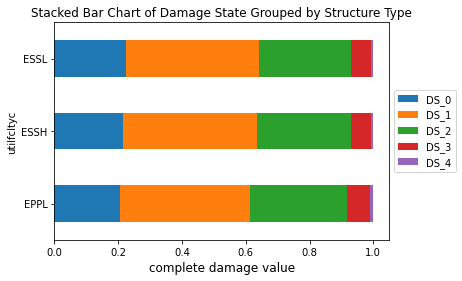

In [52]:
grouped_epf_dmg = df_sub_result.groupby(by=['utilfcltyc'], as_index=True)\
.agg({'DS_0': 'mean', 'DS_1':'mean', 'DS_2': 'mean', 'DS_3': 'mean', 'DS_4': 'mean', 'guid': 'count'})
grouped_epf_dmg.rename(columns={'guid': 'total_count'}, inplace=True)
ax = grouped_epf_dmg[["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"]].plot.barh(stacked=True)
ax.set_title("Stacked Bar Chart of Damage State Grouped by Structure Type", fontsize=12)
ax.set_xlabel("complete damage value", fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
grouped_epf_dmg.head()

##### 3-2-B) EPN Monte Carlo Analysis

In [53]:
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability

num_samples = 10000
mc_sub = MonteCarloFailureProbability(client)

result_name = fp + "3_MMSA_EPN_substations_mc_failure_probability"
mc_sub.set_input_dataset("damage", substation_dmg_result)
mc_sub.set_parameter("num_cpu", 16)
mc_sub.set_parameter("num_samples", num_samples)
mc_sub.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc_sub.set_parameter("failure_state_keys", ["DS_3", "DS_4"])

mc_sub.set_parameter("result_name", result_name) # name of csv file with results
mc_sub.run_analysis()

INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Num

True

In [54]:
substation_failure_probability = mc_sub.get_output_dataset('failure_probability')  # get buildings failure probabilities

df_substation_fail = substation_failure_probability.get_dataframe_from_csv()
df_substation_fail.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose,failure_probability
0,75941d02-93bf-4ef9-87d3-d882384f6c10,0.887433,0.523024,0.136211,0.016086,0.112567,0.364409,0.386813,0.120125,0.016086,yes,0.1291
1,35909c93-4b29-4616-9cd3-989d8d604481,0.875883,0.499762,0.123873,0.014042,0.124117,0.376121,0.375889,0.109831,0.014042,yes,0.1295
2,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,0.861667,0.473129,0.110731,0.011980,0.138333,0.388538,0.362398,0.098751,0.011980,yes,0.1163
3,b2bed3e1-f16c-483a-98e8-79dfd849d187,0.827201,0.416021,0.085761,0.008394,0.172799,0.411180,0.330260,0.077368,0.008394,yes,0.0857
4,ab011d7c-0e34-4e5d-9734-34f7858d4b68,0.825880,0.414013,0.084957,0.008286,0.174120,0.411868,0.329056,0.076671,0.008286,yes,0.0822


In [55]:
substation_damage_mcs_samples = mc_sub.get_output_dataset('sample_failure_state')

sdmcs = substation_damage_mcs_samples.get_dataframe_from_csv()
sdmcs.head()

,guid,failure
0,75941d02-93bf-4ef9-87d3-d882384f6c10,"0,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,..."
1,35909c93-4b29-4616-9cd3-989d8d604481,"1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,..."
2,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,"1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,..."
3,b2bed3e1-f16c-483a-98e8-79dfd849d187,"1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,ab011d7c-0e34-4e5d-9734-34f7858d4b68,"1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,..."


### 3-3) Water Distribution System Analysis

This section perform damage analysis of WDS including water facility and pipelines. 



#### 3-3-A) Water Facility (WF) Damage Analysis

Hazus fragility functions used to analyze the water facilities.

In [56]:
# Water facility inventory for Shelby County, TN
facility_dataset_id = "5a284f2ac7d30d13bc081e52" # Mem_water_node5.dbf = 2 node types

# Default water facility fragility mapping
#mapping_id = "5b47c3b1337d4a387e85564b"  # Hazus Potable Water Facility Fragility Mapping - Only PGA
mapping_id = "5b47c383337d4a387669d592" #Potable Water Facility Fragility Mapping for INA - Has PGD
fragility_key = "pga"

# Liquefaction parameters
liq_geology_dataset_id =  "5a284f53c7d30d13bc08249c"
liquefaction = False
liq_fragility_key = "pgd"

# Hazard uncertainty
uncertainty = False
facility_dataset = Dataset.from_data_service(facility_dataset_id, DataService(client))
df_inv_facility = facility_dataset.get_dataframe_from_shapefile()

print(df_inv_facility.utilfcltyc.unique())

INFO - collection.py:crs() - Failed to auto identify EPSG: 7


['PSTAS' 'PPPL']


In [57]:
df_inv_facility.head()

,nodenwid,fltytype,strctype,utilfcltyc,backuppowe,flow,guid,geometry
0,49,1,0,PSTAS,0,-2.0,a007a9b0-c2ec-4bdc-beec-8c92e3b515dd,POINT (-89.67220 35.38030)
1,48,1,0,PSTAS,0,-1.0,5a968e23-b0d3-4677-abd1-5767f3cad8ee,POINT (-89.91048 35.38670)
2,47,1,0,PSTAS,0,-1.0,22206135-813f-4455-9f42-7cff7b21688c,POINT (-89.95240 35.38589)
3,46,1,0,PSTAS,0,-2.0,e1bce78d-00a1-4605-95f3-3776ff907f73,POINT (-89.91344 35.36385)
4,45,1,0,PSTAS,0,-1.0,ddadb420-6057-49f6-8d29-3467906a1452,POINT (-89.94969 35.36866)


In [58]:
# Create water facility damage analysis
wf_dmg = WaterFacilityDamage(client)

# Load water facility inventory dataset
wf_dmg.load_remote_input_dataset("water_facilities", facility_dataset_id)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
wf_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [59]:
# Specify result name
result_name = fp + "2_MMSA_facility_dmg_result"

# Set analysis parameters
wf_dmg.set_parameter("result_name", result_name)
wf_dmg.set_parameter("hazard_type", hazard_type)
wf_dmg.set_parameter("hazard_id", hazard_id)
wf_dmg.set_parameter("fragility_key", fragility_key)
wf_dmg.set_parameter("use_liquefaction", liquefaction)
wf_dmg.set_parameter("liquefaction_geology_dataset_id", liq_geology_dataset_id)
wf_dmg.set_parameter("liquefaction_fragility_key", liq_fragility_key)
wf_dmg.set_parameter("use_hazard_uncertainty", uncertainty)
wf_dmg.set_parameter("num_cpu", 4)

True

In [60]:
# Run water facility damage analysis
wf_dmg.run_analysis()

INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.


True

In [61]:
waterfacility_dmg_result = wf_dmg.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
df_waterfacility_dmg = waterfacility_dmg_result.get_dataframe_from_csv()
df_waterfacility_dmg.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,a007a9b0-c2ec-4bdc-beec-8c92e3b515dd,0.920681,0.600414,0.183840,0.024956,0.079319,0.320266,0.416574,0.158884,0.024956,yes
1,5a968e23-b0d3-4677-abd1-5767f3cad8ee,0.940153,0.655722,0.225295,0.033957,0.059847,0.284431,0.430426,0.191339,0.033957,yes
2,22206135-813f-4455-9f42-7cff7b21688c,0.939535,0.653812,0.223743,0.033598,0.060465,0.285723,0.430069,0.190145,0.033598,yes
3,e1bce78d-00a1-4605-95f3-3776ff907f73,0.930022,0.625784,0.201989,0.028748,0.069978,0.304238,0.423795,0.173241,0.028748,yes
4,ddadb420-6057-49f6-8d29-3467906a1452,0.931985,0.631374,0.206179,0.029656,0.068015,0.300611,0.425195,0.176524,0.029656,yes


#### 3-3-B) Water Facility (WF) MC Simulations

In [62]:
mc_wf = MonteCarloFailureProbability(client)
num_samples = 10000
mc_wf.set_input_dataset("damage", waterfacility_dmg_result)
mc_wf.set_parameter("result_name", "wf_dmg_mc")
mc_wf.set_parameter("num_cpu", 8)
mc_wf.set_parameter("num_samples", num_samples)
mc_wf.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc_wf.set_parameter("failure_state_keys", ["DS_3", "DS_4"])
mc_wf.run_analysis()

INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - Num

True

In [63]:
# get water facility failure probabilities
waterfacility_failure_probability = mc_wf.get_output_dataset('failure_probability')  
df_waterfacility_fail = waterfacility_failure_probability.get_dataframe_from_csv()
df_waterfacility_fail.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose,failure_probability
0,a007a9b0-c2ec-4bdc-beec-8c92e3b515dd,0.920681,0.600414,0.183840,0.024956,0.079319,0.320266,0.416574,0.158884,0.024956,yes,0.1837
1,5a968e23-b0d3-4677-abd1-5767f3cad8ee,0.940153,0.655722,0.225295,0.033957,0.059847,0.284431,0.430426,0.191339,0.033957,yes,0.2295
2,22206135-813f-4455-9f42-7cff7b21688c,0.939535,0.653812,0.223743,0.033598,0.060465,0.285723,0.430069,0.190145,0.033598,yes,0.2160
3,e1bce78d-00a1-4605-95f3-3776ff907f73,0.930022,0.625784,0.201989,0.028748,0.069978,0.304238,0.423795,0.173241,0.028748,yes,0.2071
4,ddadb420-6057-49f6-8d29-3467906a1452,0.931985,0.631374,0.206179,0.029656,0.068015,0.300611,0.425195,0.176524,0.029656,yes,0.2080


#### 3-3-C) Pipeline Damage and Servicability Analysis

Pipelines are analyzed using PipelineDamageRepairRate module of pyincore and subsequently the servicability index for each pipeline is estimated using Hazus procedure [5]


In [64]:
# Water Buried Pipeline inventory in Shelby county, TN
pipeline_dataset_id = "5a284f28c7d30d13bc081d14"

# pipeline fragility mapping
mapping_id = "5b47c227337d4a38464efea8"

# Geology dataset
liq_geology_dataset_id = "5a284f53c7d30d13bc08249c"
liq_fragility_key = "pgd"

use_liq = True
use_liq = False

In [65]:
pipeline_dataset = Dataset.from_data_service(pipeline_dataset_id, DataService(client))
df_inv_pipeline = pipeline_dataset.get_dataframe_from_shapefile()
df_inv_pipeline["x"] = df_inv_pipeline.centroid.map(lambda p: p.x)
df_inv_pipeline["y"] = df_inv_pipeline.centroid.map(lambda p: p.y)
df_inv_pipeline.head()

,linknwid,fromnode,tonode,direction,pipetype,jointtype,diameter,length,soiltype,capacity,guid,pipelinesc,pipelinehz,geometry,x,y
0,70,46,48,0,Welded Steel,Lap Arc Welded,2.0,2.55,Corrosive,2000.0,0a076a0d-54fa-4f82-a8af-ce3bd227fcfa,PWP2,1,"LINESTRING (-89.91048 35.38670, -89.91344 35.3...",-89.911958,35.375274
1,63,38,41,0,Welded Steel,Lap Arc Welded,2.0,2.18,Corrosive,2000.0,cee37f5e-6e62-40e6-be5a-485d5c78bd25,PWP2,1,"LINESTRING (-89.75848 35.33466, -89.76512 35.3...",-89.761802,35.325240
2,4,2,3,0,Welded Steel,Lap Arc Welded,2.0,11.10,Corrosive,2000.0,77f5d8b6-ad73-4959-b357-0c512d8f2bcd,PWP2,1,"LINESTRING (-90.11234 35.02180, -90.11320 35.0...",-90.060825,35.014531
3,33,10,30,1,Welded Steel,Lap Arc Welded,2.0,5.26,Corrosive,2000.0,07267d06-089e-4db7-a479-1794cdc23be3,PWP2,1,"LINESTRING (-89.76882 35.20369, -89.74608 35.1...",-89.757452,35.181865
4,59,32,36,0,Welded Steel,Lap Arc Welded,2.0,12.20,Corrosive,2000.0,ec3d4c41-ae4a-4489-9984-1d96e7f4ae06,PWP2,1,"LINESTRING (-89.65750 35.20729, -89.65645 35.2...",-89.685531,35.249394


In [66]:
# Create pipeline damage with repair rate
pipeline_dmg_w_rr = PipelineDamageRepairRate(client)

# Load pipeline inventory as input datasets
pipeline_dmg_w_rr.load_remote_input_dataset("pipeline", pipeline_dataset_id)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
pipeline_dmg_w_rr.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [67]:
# Specify the result name
result_name = fp + "2_MMSA_pipeline_dmg_result"

# Set analysis parameters
pipeline_dmg_w_rr.set_parameter("result_name", result_name)
pipeline_dmg_w_rr.set_parameter("hazard_type", hazard_type)
pipeline_dmg_w_rr.set_parameter("hazard_id", hazard_id)
pipeline_dmg_w_rr.set_parameter("liquefaction_fragility_key", liq_fragility_key)
pipeline_dmg_w_rr.set_parameter("liquefaction_geology_dataset_id",liq_geology_dataset_id)
pipeline_dmg_w_rr.set_parameter("use_liquefaction", use_liq)
pipeline_dmg_w_rr.set_parameter("num_cpu", 4)

True

In [68]:
# Run pipeline  damage analysis
pipeline_dmg_w_rr.run_analysis()

INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.
INFO - utils.py:_init_num_threads() - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - utils.py:_init_num_threads() - NumExpr defaulting to 8 threads.


True

In [69]:
# Retrieve result dataset
pipline_dmg_result = pipeline_dmg_w_rr.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
df_pipline_dmg = pipline_dmg_result.get_dataframe_from_csv()
df_pipline_dmg.head()

,guid,pgvrepairs,pgdrepairs,repairspkm,breakrate,leakrate,failprob,numpgvrpr,numpgdrpr,numrepairs,haz_expose
0,0a076a0d-54fa-4f82-a8af-ce3bd227fcfa,0.009045,0.0,0.009045,0.001809,0.007236,0.004602,0.023065,0.0,0.023065,yes
1,cee37f5e-6e62-40e6-be5a-485d5c78bd25,0.007119,0.0,0.007119,0.001424,0.005695,0.003099,0.015519,0.0,0.015519,yes
2,77f5d8b6-ad73-4959-b357-0c512d8f2bcd,0.002919,0.0,0.002919,0.000584,0.002335,0.006459,0.032402,0.0,0.032402,yes
3,07267d06-089e-4db7-a479-1794cdc23be3,0.004505,0.0,0.004505,0.000901,0.003604,0.004728,0.023698,0.0,0.023698,yes
4,ec3d4c41-ae4a-4489-9984-1d96e7f4ae06,0.005289,0.0,0.005289,0.001058,0.004231,0.012821,0.064521,0.0,0.064521,yes


In [70]:
df_WDS_links = pd.merge(df_WDSlinks, df_pipline_dmg, on='guid', how='outer')
df_WDSlinks.head()

,linknwid,fromnode,tonode,direction,pipetype,jointtype,diameter,length,soiltype,capacity,...,repairspkm,breakrate,leakrate,failprob,numpgvrpr,numpgdrpr,numrepairs,haz_expose,PGVfailpro,geometry
0,70,46,48,1,Welded Steel,Lap Arc Welded,2.0,2.55,Corrosive,2000.0,...,3.263349,2.609711,0.653638,0.998712,0.004114,8.317425,8.321540,yes,0.004106,"LINESTRING (-89.91048 35.38670, -89.91344 35.3..."
1,63,41,38,0,Welded Steel,Lap Arc Welded,2.0,2.18,Corrosive,2000.0,...,1.816326,1.452299,0.364027,0.957829,0.002768,3.956822,3.959590,yes,0.002764,"LINESTRING (-89.75848 35.33466, -89.76512 35.3..."
2,4,2,3,1,Welded Steel,Lap Arc Welded,2.0,11.10,Corrosive,2000.0,...,1.637020,1.309304,0.327717,1.000000,0.005780,18.165148,18.170927,yes,0.005763,"LINESTRING (-90.11234 35.02180, -90.11320 35.0..."
3,33,10,30,1,Welded Steel,Lap Arc Welded,2.0,5.26,Corrosive,2000.0,...,1.637303,1.309361,0.327943,0.998979,0.004227,8.607989,8.612216,yes,0.004218,"LINESTRING (-89.76882 35.20369, -89.74608 35.1..."
4,59,32,36,1,Welded Steel,Lap Arc Welded,2.0,12.20,Corrosive,2000.0,...,1.637443,1.309388,0.328055,1.000000,0.011509,19.965297,19.976806,yes,0.011443,"LINESTRING (-89.65750 35.20729, -89.65645 35.2..."


For pipelines, Hazus [5] assumes two damage states consist of: leaks and breaks. When a pipe is damaged due to ground failure (PGD), the type of damage is likely to be a break, while when a pipe is damaged due to seismic wave propagation (PGV), the type of damage is likely to be joint pull-out or crushing at the bell, which generally cause leaks. In the Hazus Methodology, it is assumed that damage due to seismic waves will consist of 80% leaks and 20% breaks, while damage due to ground failure will consist of 20% leaks and 80% breaks. Servicability index can be calculated using the following equation

$$ SI = 1 - Lognormal(ARR, 0.1, 0.85) $$

Where SI is servicability index, ARR is average repair rate and the lognormal function has a median of 0.1 repairs/km and a beta of 0.85, and . Please refer to section 8.1.7 of Hazs (Water System Performance) for further information

In [71]:
from scipy import stats
import math
for idx in df_WDSlinks['linknwid']:
    df = df_WDSlinks[df_WDSlinks.linknwid.isin([idx])]

    # standard deviation of normal distribution
    sigma = 0.85
    
    # mean of normal distribution
    mu = math.log(.1)
    
    C_pgv = 0.2 # 0.2
    C_pgd = 0.8 # 0.8
    im = (C_pgv * df['numpgvrpr'] + C_pgd * df['numpgdrpr']).sum()/df['length'].sum()
    SI_break = 1-stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(im)
    
    C_pgv = 0.8  # 0.2
    C_pgd = 0.2  # 0.8
    im = (C_pgv * df['numpgvrpr'] + C_pgd * df['numpgdrpr']).sum()/df['length'].sum()
    SI_leak = 1-stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(im)
    
    m = df_WDSlinks['linknwid'] == idx
    df_WDSlinks.loc[m, ['SI_break_idv']] = SI_break
    df_WDSlinks.loc[m, ['SI_leak__idv']] = SI_leak


# 4) Restoration and Functionality Analysis

### 4-1) NetworkX Modeling of EPN and WDS networks

To perform restoration and functionality analysis of infrastruture, first a directed graph model of the EPN and WDS, given by G_EPN and G_WDS, is developed. Subsequently, these two networkX graphs are combined to obtain an interdependednt graph of two networks given by G_EPN_WDS; this graph can be represented by an $n×n$ adjacency matrix $M(G)=[m_{ij}]$. [7]

In [ ]:
### shp_to_network functions takes node and edge shapefiles of an infrastruture network
### and constructs a networkX graph give by G

def shp_to_network(df_network_nodes, df_network_links, sort = 'unsorted'):
    
    G=nx.DiGraph() #Empty graph

    X = df_network_nodes['geometry'].apply(lambda p: p.x).head()
    Y = df_network_nodes['geometry'].apply(lambda p: p.y).head()
    ID = df_network_nodes['nodenwid']

    pos = {}
    X = df_network_nodes['geometry'].apply(lambda p: p.x)
    Y = df_network_nodes['geometry'].apply(lambda p: p.y)
    for i, val in enumerate(df_network_nodes["nodenwid"]):
        pos[val] = (X[i],Y[i])

    edges = [(x,y) for x, y in zip(df_network_links["fromnode"],df_network_links["tonode"])]
    edge = []

    if sort == 'sorted':
        for i, val in enumerate(df_network_links["linknwid"]):
            if df_network_links["direction"][i] == 1:
                edge.append((df_network_links["fromnode"][i],df_network_links["tonode"][i]))
            else:
                edge.append((df_network_links["tonode"][i],df_network_links["fromnode"][i]))
    elif sort == 'unsorted':
        for i, val in enumerate(df_network_links["linknwid"]):
            edge.append((df_network_links["fromnode"][i],df_network_links["tonode"][i]))        

    G.add_nodes_from(pos.keys())
    G.add_edges_from(edge)
    for x, y, id in zip(X,Y,ID):
        G.nodes[id]['pos'] = (x,y)

    for ii,ID in enumerate(G.nodes()):
        G.nodes[ID]["classification"] = df_network_nodes["utilfcltyc"][ii]
    
    return G


In [ ]:
### Obtain networkX representation of EPN and WDS networks
G_EPN = shp_to_network(df_EPNnodes,df_EPNlinks)
G_WDS = shp_to_network(df_WDSnodes,df_WDSlinks)

In [ ]:
### Add 100 to node and link IDs of EPN geodataframe to distinguish its node IDs from WDS
df_EPNlinks['linknwid'] = df_EPNlinks['linknwid'] + 100
df_EPNlinks['fromnode'] = df_EPNlinks['fromnode'] + 100
df_EPNlinks['tonode'] = df_EPNlinks['tonode'] + 100
df_EPNnodes['nodenwid'] = df_EPNnodes['nodenwid'] + 100

### 4-2) Restoration Analysis of EPN Components

Restoration curves for electric substations presented in Hazus [5] are emplyed to perform retoration analysis of EPN substations. These functions are presented in Table 8-28 which provide  approximate discrete functions for the restoration of EPN components.

In [ ]:
df_EPN_node = pd.merge(df_EPNnodes[['nodenwid','utilfcltyc','guid']], df_substation_fail[['guid','DS_0', 'DS_1', 'DS_2', 'DS_3','DS_4', 'failure_probability']], on='guid', how='outer')
### Discretized Restoration Functions for substations
rest_dict = {1:  [100,  50,   9,   4,  3],
             3:  [100, 100,  50,  13,  4],
             7:  [100, 100, 100,  50,  7],
            30:  [100, 100, 100, 100,  50],
            90:  [100, 100, 100, 100, 100]}

for key in [1, 3, 7, 30, 90]:
    C0, C1, C2, C3, C4 = rest_dict[key][0],rest_dict[key][1],rest_dict[key][2],rest_dict[key][3],rest_dict[key][4]
    def f(row):
        func = (C0*row['DS_0'] + C1*row['DS_1'] + C2*row['DS_2'] + C3*row['DS_3'] + C4*row['DS_4'])/100
        return func
    df_EPN_node['functionality'+str(key)] = df_EPN_node.apply(f, axis=1)
df_EPN_node.head()

### 4-3) Restoration Analysis of WDS Components

Restoration curves for WDS presented in Hazus are emplyed to perform retoration analysis of WDS nodes. These functions are presented in Table 8-2, which provide  approximate discrete functions for the restoration of Potable Water System Components.

In [ ]:
df_WDS_node = pd.merge(df_WDSnodes[['nodenwid','utilfcltyc','guid']], df_waterfacility_dmg[['guid', 'DS_0', 'DS_1', 'DS_2', 'DS_3','DS_4']], on='guid', how='outer')

### Discretized Restoration Functions for 'PSTAS': Above Ground Steel Tank
PSTASrest_dict = {1:  [100,  30,  20,  13,  10],
                  3:  [100, 100,  49,  15,  11],
                  7:  [100, 100,  93,  16,  12],
                 30:  [100, 100, 100,  23,  15],
                 90:  [100, 100, 100,  40,  30]}

### Discretized Restoration Functions for 'PPPL': Large Pump Plant
PPPLrest_dict = {1:  [100,  65,  22,  10,   3],
                 3:  [100, 100,  50,  15,   4],
                 7:  [100, 100, 100,  25,   6],
                30:  [100, 100, 100,  95,  40],
                90:  [100, 100, 100, 100, 100]}

for key in [1, 3, 7, 30, 90]:
    def f(row):
        if row['utilfcltyc'] == 'PSTAS':
            C0, C1, C2, C3, C4 = PSTASrest_dict[key][0],PSTASrest_dict[key][1],PSTASrest_dict[key][2],PSTASrest_dict[key][3],PSTASrest_dict[key][4]
            func = (C0*row['DS_0'] + C1*row['DS_1'] + C2*row['DS_2'] + C3*row['DS_3'] + C4*row['DS_4'])/100
            return func
        elif row['utilfcltyc'] == 'PPPL':
            C0, C1, C2, C3, C4 = PPPLrest_dict[key][0],PPPLrest_dict[key][1],PPPLrest_dict[key][2],PPPLrest_dict[key][3],PPPLrest_dict[key][4]
            func = (C0*row['DS_0'] + C1*row['DS_1'] + C2*row['DS_2'] + C3*row['DS_3'] + C4*row['DS_4'])/100
            return func
    df_WDS_node['functionality'+str(key)] = df_WDS_node.apply(f, axis=1)
df_WDS_node.head()    

### 4-4) NetworkX modeling of interdependent EPN and WDS networks

#### 4-4-A) The EPN and WDS pecentage functionality dataframes are combined in this section to obtain an interdependent networkX model of EPN and WDS.

In [ ]:
df_functionality_nodes = df_EPN_node.append(df_WDS_node, ignore_index=True)
df_network_nodes = df_EPNnodes.append(df_WDSnodes, ignore_index=True)
df_network_links = df_EPNlinks.append(df_WDSlinks, ignore_index=True)

In [ ]:
### Obtain an interdepentend graph model of networks
G_WDS_EPN_Full = shp_to_network(df_network_nodes,df_network_links)
G_EPN_WDS_Full = shp_to_network(df_network_nodes,df_network_links)

#### 4-4-B) Assign SI values obtained from pipeline repair analysis as weight to networkX model

In [ ]:
for nodes in df_WDS_node['nodenwid']:
    if len(list(G_WDS_EPN_Full.predecessors(nodes))) > 0:
        for node in list(G_WDS_EPN_Full.predecessors(nodes)):
            weight = df_WDSlinks[df_WDSlinks['fromnode']==node].SI_break_idv.values[0]
            G_WDS_EPN_Full[node][nodes]['weight'] = weight
            G_EPN_WDS_Full[node][nodes]['weight'] = weight

#### 4-4-C) Define the dependency between EPN and WDS with additional edges within the networkX model

In [ ]:
master_EPN = [113,116,125,127,128,132,135,137,139]
slave_WDS  = [4  ,5  ,12 ,2  ,3  ,6  ,8  ,9  ,11]
for i, j in zip(master_EPN,slave_WDS):
    G_WDS_EPN_Full.add_edge(i,j)

In [ ]:
master_WDS = [ 21,  25,  23 ,  29,  30,  35,  39, 42]
slave_EPN  = [101, 102, 103 , 104, 105, 106, 107, 108]
for i, j in zip(master_WDS,slave_EPN):
    G_EPN_WDS_Full.add_edge(i,j)

### 4-5) Implemention of an Input-Output model to estimate the functionality of EPN nodes by accounting for dependency between EPN and WDS networks

The functionality estimates obtained for buildings, EPN and WDS are used as input to an input-output (I-O) model [6] to simulate the functionality of components by accounting for the interdependency between networked infrastructure. 

An I-O model uses a perturbation vector, given by $u$, to capture the inoperability of the components of a disrupted interconnected system due to cascading effects.

$$
q=M(G)q+u
$$

where $u = [u_1,u_2,…,u_n]^T$; $u_i∈[0,1]⊂R$ is the perturbation vector obtained from non-functionality of individual network components subject to seismic hazard and $q=[q_1,q_2,…,q_n]^T]$; $q_i∈[0,∞)⊂R$ is the resulting non-functionality vector due to their connections to the perturbed infrastructure components and their cascading failure. The non-functionally vector $q$ can be calculated as follows: 

$$
q=(I-M(G)^T)^{-1} u
$$

Ultimately, functionality vector can be calculated as

$$
functionality = 1-q
$$

In [ ]:
# Obtain percent functionality estimates days after the event by running the input-output model
for idx in [1,3,7,30,90]:
    day = str(idx)

    from numpy.linalg import inv
    M = nx.adjacency_matrix(G_EPN_WDS_Full).todense()

    u = 1-df_functionality_nodes['functionality'+day]
    u = u.to_numpy()
    
    I = np.identity(len(u))
    
    q = np.dot(np.linalg.inv(I-M.T),u).tolist()[0]
    
    funct = [0 if i >=1 else 1-i for i in q]
    df_functionality_nodes['func_cascading'+ day] = funct

In [ ]:
# update the column attribute for substations to 'sugid'
df_functionality_nodes = df_EPNnodes[['guid','geometry']].merge(df_functionality_nodes, on = 'guid', how = 'left').rename(columns={'guid': 'sguid'})
df_functionality_nodes.head()

#### Functionality of EPN 7 and 30 days after event

In [ ]:
day = '7'
ax = df_functionality_nodes.query('nodenwid>100').plot(figsize=(20, 10),column='func_cascading'+ day, markersize=200, edgecolor='k', alpha=1, legend=True, cmap='jet_r',  vmin=0, vmax=1)
df_EPNlinks.plot(ax=ax,color='k', alpha=1, linewidths=1., vmin=0, vmax=1)
ax.set_axis_off()
day = '30'
ax = df_functionality_nodes.query('nodenwid>100').plot(figsize=(20, 10),column='func_cascading'+ day, markersize=200, edgecolor='k', alpha=1, legend=True, cmap='jet_r',  vmin=0, vmax=1)
df_EPNlinks.plot(ax=ax,color='k', alpha=1, linewidths=1., vmin=0, vmax=1)
ax.set_axis_off()

#### 4-5-A) Analysisi of WDS Functionality Estimates obtained from I-O model 

In this section, we map the WDS functionality estimates to general functional and nonfucntional categories. According to Hazus [5], WDS functionality can be classified as follows:

•  0-25% functionality – building/facility is likely to be non-functional  
•  25-75% functionality – building/facility is likely to allow limited operations (e.g., selected parts of the building/facility may be used)  
•  75-100% functionality – building/facility is likely to be functional

This notebook assumes functionality 0-25% as non-functional and 25-100% as functional.

In [ ]:
df_wf_functionality = df_functionality_nodes.query('nodenwid<100')[['nodenwid','sguid', 'functionality1', 'functionality3',
       'functionality7', 'functionality30', 'functionality90',
       'func_cascading1', 'func_cascading3', 'func_cascading7',
       'func_cascading30', 'func_cascading90']]
cols = ['functionality1', 'functionality3',
       'functionality7', 'functionality30', 'functionality90',
       'func_cascading1', 'func_cascading3', 'func_cascading7',
       'func_cascading30', 'func_cascading90']
for key in cols:
    df_wf_functionality.loc[df_wf_functionality[key] <0.25, key] = 0 
    df_wf_functionality.loc[(0.25<=df_wf_functionality[key]) & (df_wf_functionality[key]<0.75), key] = 1
    df_wf_functionality.loc[df_wf_functionality[key] >=0.75, key] = 1
df_wf_functionality.head()

#### 4-5-B) Analysisi of EPN Functionality Estimates obtained from I-O model 

In [ ]:
df_ss_functionality = df_functionality_nodes.query('nodenwid>100')[['nodenwid','sguid', 'func_cascading1', 'func_cascading3', 'func_cascading7',
       'func_cascading30', 'func_cascading90']]
cols = ['func_cascading1', 'func_cascading3', 'func_cascading7',
       'func_cascading30', 'func_cascading90']
df_ss_functionality.head()


In [ ]:
df_bldg_functionality = df_bldg_func.rename(columns={'functionality':'bldg_functionality'})[['guid','bldg_functionality']]
df_EPN_Bldg_Depend = df_EPN_Bldg_Depend.merge(df_ss_functionality, on = 'sguid', how = 'left')
df_EPN_Bldg_Depend = df_EPN_Bldg_Depend.merge(df_bldg_functionality, on = 'guid', how = 'left')
df_EPN_Bldg_Depend

The following code generates samples to simulates the pecentage of buildings nonfunctional given the functionality percantage of substations obtained previously. The mean of functionality estimates obtained from multiplying the functionality of buildings and their associated EPN substation gives the functionality of each building.

In [ ]:
df_EPN_Bldg_Depend_MC = df_EPN_Bldg_Depend.copy()

columns = ['guid', 'sguid', 'nodenwid', 'func_cascading1','func_cascading3', 'func_cascading7', 'func_cascading30','func_cascading90']
df_EPN_Bldg_functionality =  df_EPN_Bldg_Depend[['guid', 'sguid', 'nodenwid', 'func_cascading1',
       'func_cascading3', 'func_cascading7', 'func_cascading30',
       'func_cascading90']].copy()
for col in columns[3:]:
    df_EPN_Bldg_functionality[col].values[:] = 0

no_samples = 100
for MC_sample in range(0,no_samples):
    for sguid in df_EPN_Bldg_Depend_MC.sguid.unique():
        ss_row  = df_ss_functionality.loc[df_ss_functionality['sguid'] == sguid]
        bldg_rows = df_EPN_Bldg_Depend_MC.loc[df_EPN_Bldg_Depend_MC['sguid'] == sguid]
        for idx in [1, 3, 7, 30, 90]:
            day = str(idx)
            percent_functional = ss_row['func_cascading'+day].values[0]
            percent_functional = percent_functional if percent_functional<1 else 1
            nums = np.random.choice([1, 0], size=len(bldg_rows), p=[percent_functional, 1-percent_functional])
            df_EPN_Bldg_Depend_MC.loc[df_EPN_Bldg_Depend_MC['sguid'] == sguid, 'func_cascading'+day] = nums
    for idx in [1, 3, 7, 30, 90]:
        day = str(idx)
        df_EPN_Bldg_functionality['func_cascading'+day] = df_EPN_Bldg_functionality['func_cascading'+day] + (1/no_samples)*df_EPN_Bldg_Depend_MC['func_cascading'+day] * df_EPN_Bldg_Depend_MC['bldg_functionality']
    
df_EPN_Bldg_functionality
            
            

In [ ]:
### Merge EPN functionality estimates with EPN shapefile for plotting
df_EPN_Bldg_functionality_gdf = bldg_gdf.merge(df_EPN_Bldg_functionality, on = 'guid', how = 'left')

### 4-6) Results obtain for functionality of buildings by accounting for the interdependency between buildings and EPN network

Example results obtain for functionality of buildings 1 day, 7 days and 30 days after an event

#### 1 Day After Event

In [ ]:
viz.plot_gdf_map(df_EPN_Bldg_functionality_gdf, 'func_cascading1', basemap=True)

#### 7 Days After Event

In [ ]:
viz.plot_gdf_map(df_EPN_Bldg_functionality_gdf, 'func_cascading7', basemap=True)

#### 30 Days After Event

In [ ]:
viz.plot_gdf_map(df_EPN_Bldg_functionality_gdf, 'func_cascading30', basemap=True)

#### Number of buildings having functionality estimates greater or equal 0.5 days after event

In [ ]:
df_EPN_Bldg_functionality[columns[3:]][df_EPN_Bldg_functionality[columns[3:]] >= 0.5].count()